In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
%pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
import pandas as pd

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
def run_grid_search_rf(X_train, y_train, cv_folds, param_grid):
    rf = RandomForestClassifier(random_state=42)

    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv_folds, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

def run_rf_smote(majors, columns_to_include, depression_threshold, k_folds=5, param_grid=None):
    results = []
    print(f"For depression threshold of {depression_threshold}, with {k_folds}-cross validation.")
    
    for major in majors:
        print(f"Processing major: {major}")

        data = pd.read_csv(f'../Data/clean_df_{major}.csv')

        data = data[[col for col in columns_to_include if col in data.columns]]

        data['Depression_Score'] = data['Depression_Score'].apply(lambda x: 1 if x > depression_threshold else 0)

        y = data['Depression_Score']
        X = data.drop(columns=['Depression_Score'])
        X = X.apply(pd.to_numeric, errors='coerce').dropna()
        y = y[X.index]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        scaler = MinMaxScaler()
        X_train_resampled = pd.DataFrame(scaler.fit_transform(X_train_resampled), columns=X.columns)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

        if param_grid is None:
            param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
            }

        best_model, best_params, best_score = run_grid_search_rf(X_train_resampled, y_train_resampled, k_folds, param_grid)

        kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
        cross_val_scores = cross_val_score(best_model, X_train_resampled, y_train_resampled, cv=kf, scoring='accuracy')
        mean_cv_score = round(cross_val_scores.mean(), 5)

        results.append({
            'major': major,
            'best_params': best_params,
            'grid_search_score': best_score,
            'mean_cv_score': mean_cv_score
        })

    return results

In [3]:
def print_results(results):
    print("\nModel Performance Summary:")
    for result in results:
        print(f"Major: {result['major']}")
        print(f"Best Parameters: {result['best_params']}")
        print(f"Grid Search Score: {result['grid_search_score']:.5f}")
        print(f"Mean Cross-Validation Score: {result['mean_cv_score']:.5f}")
        print("-" * 50)

majors = ['main', 'business', 'compsci', 'engineering', 'law', 'medical', 'others']

columns_to_include = [
    'Age', 'CGPA', 'Stress_Level', 'Depression_Score', 
    'Anxiety_Score', 'Financial_Stress', 'Semester_Credit_Load'
]

depression_threshold = 4

k_folds = 5

results = run_rf_smote(majors, columns_to_include, depression_threshold, k_folds)

print_results(results)

For depression threshold of 4, with 5-cross validation.
Processing major: main
Processing major: business
Processing major: compsci
Processing major: engineering
Processing major: law
Processing major: medical
Processing major: others

Model Performance Summary:
Major: main
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Grid Search Score: 0.83791
Mean Cross-Validation Score: 0.83628
--------------------------------------------------
Major: business
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Grid Search Score: 0.89452
Mean Cross-Validation Score: 0.87694
--------------------------------------------------
Major: compsci
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Grid Search Score: 0.74433
Mean Cross-Validation Score: 0.72778
--------------------------------------------------
Major: engineering
Best Parameters: {'

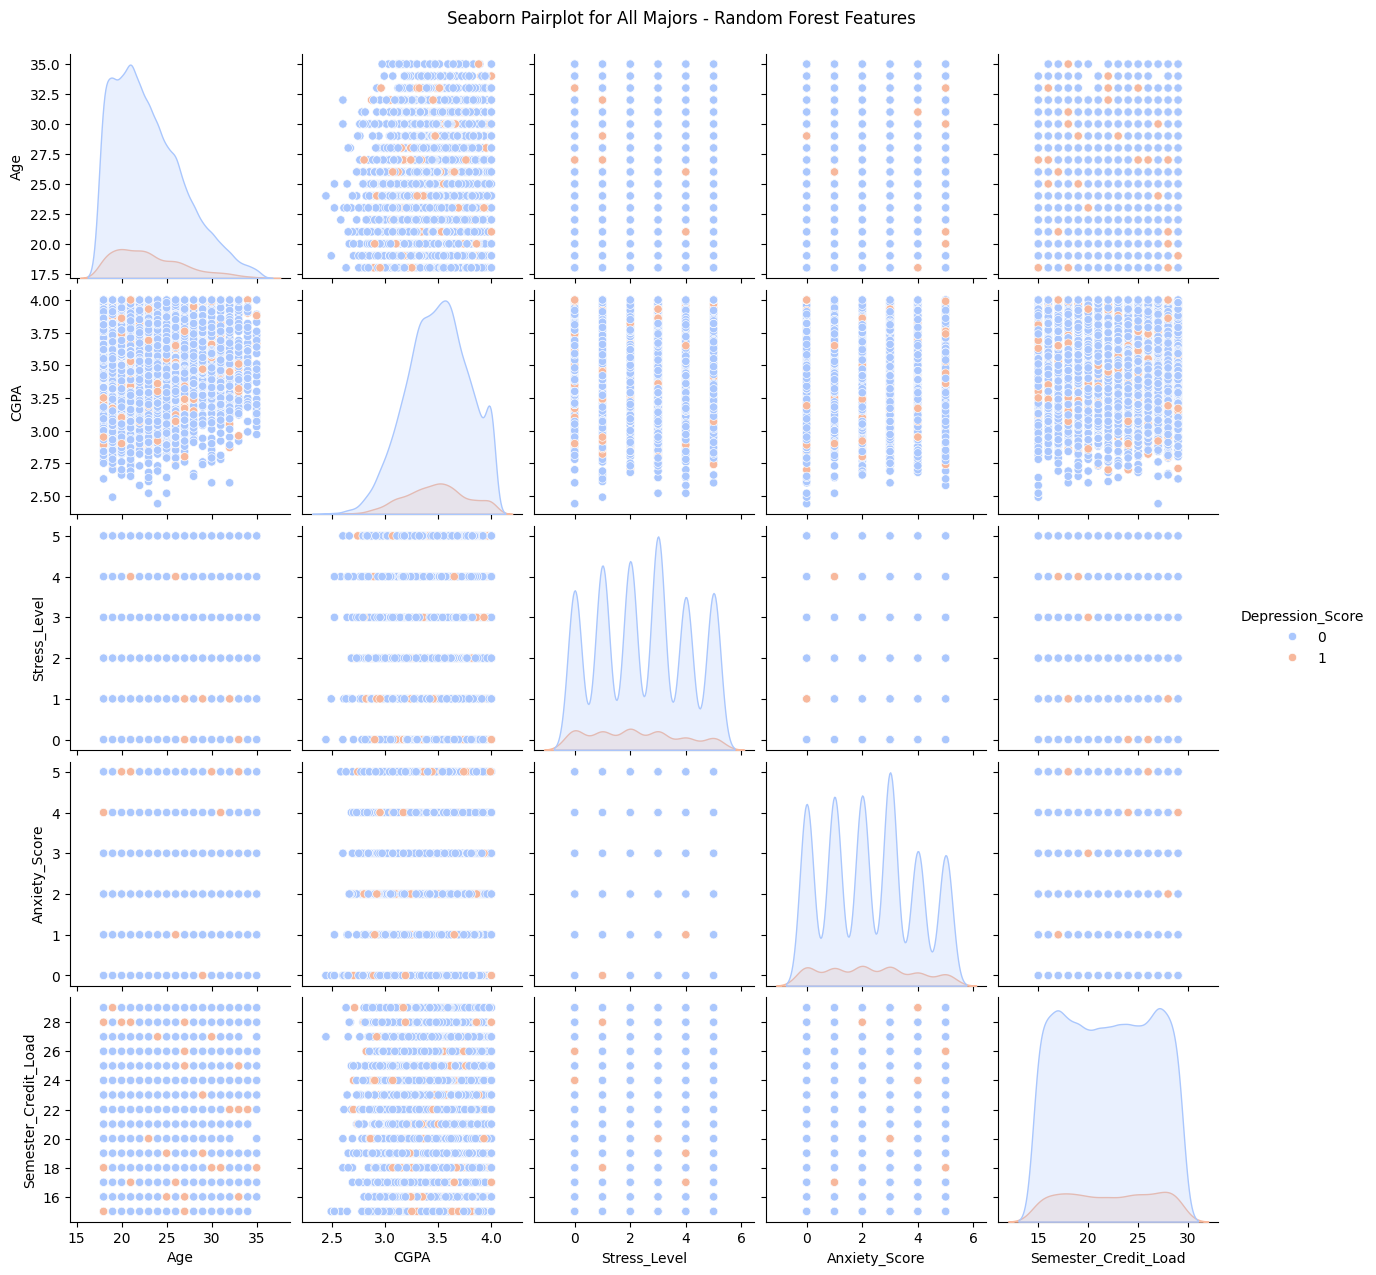

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

majors = ['main', 'business', 'compsci', 'engineering', 'law', 'medical', 'others']

columns_to_include = [
    'Age', 'CGPA', 'Stress_Level', 
    'Depression_Score', 'Anxiety_Score', 
    'Financial_Stress', 'Semester_Credit_Load'
]

all_data = []
for major in majors:
    file_path = f'../Data/clean_df_{major}.csv'
    data = pd.read_csv(file_path)
    data['Major'] = major  
    all_data.append(data)

combined_data = pd.concat(all_data, ignore_index=True)

combined_data = combined_data[[col for col in columns_to_include if col in combined_data.columns] + ['Major']]

depression_threshold = 4
combined_data['Depression_Score'] = combined_data['Depression_Score'].apply(lambda x: 1 if x > depression_threshold else 0)

# Pairplot with hue set to Depression_Score
sns.pairplot(combined_data, 
             vars=['Age', 'CGPA', 'Stress_Level', 'Anxiety_Score', 'Semester_Credit_Load'], 
             hue='Depression_Score', 
             diag_kind='kde', 
             palette='coolwarm')

plt.suptitle("Seaborn Pairplot for All Majors - Random Forest Features", y=1.02)
plt.show()
